# Squeezed Lasing: symmetry-broken states ($\varphi$ variation)

In [75]:
import math as math
import numpy as np
import scipy as scipy
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import sys
import os

from qutip import *
from src_2_0 import *

In [76]:
def H_def(a,sigma,Delta_c,Delta_0,g,r,theta,omega=0,phi=0): # Defines the Hamiltonian of the system. It considers a coupling between a photonic cavity and a one-atom subsystem.
    return Delta_c*a.dag()*a+Delta_0*sigma.dag()*sigma+g*(sigma*(np.cosh(r)*a.dag()+np.exp(1j*theta)*np.sinh(r)*a)+sigma.dag()*(np.cosh(r)*a+np.exp(-1j*theta)*np.sinh(r)*a.dag()))+omega*(a*np.exp(-1j*phi)+a.dag()*np.exp(1j*phi))

In [77]:
def Lops_def(a,sigma,k,P,eta): # Defines the system's collapse (Lindblad) operators, one that represents incoherent pumping and other that describes photon loss.
    return [np.sqrt(P)*sigma.dag(),np.sqrt(k*(1+eta))*a]

#### Parameters

In [78]:
### General parameters ###

N = 300 # Dimension of the Hilbert space of the cavity
n_q = 100 # Photon saturation number
C = 1 # Cooperativity (equal to the pumping parameter p)
eta = 0 # Photon loss due to other decay channels

### Hamiltonian parameters ###

g_0 = 10**(-5.9) # Light-matter coupling
Delta = 1 # Detunings Delta_s = Delta_r
r = 1 # Squeezing parameter
theta = np.pi # Squeezing angle
Omega_r = 1e-2

### Symmetry broken parameters ###

omega = 2*1e-7 # Amplitude of the coherent driving with well defined phase
phi = np.linspace(-np.pi/2,2*np.pi-np.pi/2,25) # Fixed phase

#### Parameter-dependent quantities

In [79]:
k = g_0*np.sqrt(2/(C*n_q)) # Photon decay rate
P = 2*n_q*k # Incoherent pumping
g = g_0*np.cosh(r)
C_s = C*np.cosh(r)**2 # Squeezed cooperativity (equal to the squeezed pumping parameter p_s)

In [80]:
delta_c = (4*g**2*np.cosh(r)**2*Delta)/Omega_r**2 # Chosen like this so that Delta_c and Delta_0 are zero
Delta_1 = -(Omega_r**2/(4*Delta))*(1-np.tanh(r)**2)

#### Operators

In [81]:
a = tensor(destroy(N),identity(2)) # Annihilation operator
sigma = tensor(identity(N),basis(2,0)*basis(2,1).dag()) # Lowering operator of the two-level system
S = (0.5*(r*np.exp(-1j*theta)*a*a-np.conj(r*np.exp(-1j*theta))*a.dag()*a.dag())).expm() # Squeezing operator

#### Collapse operators

In [82]:
Lops = Lops_def(a,sigma,k,P,eta) # Iniatilize the collapse operators for the chosen parameters

#### Steady-states

In [83]:
rho_ss = [] # Steady states of the system

for i in tqdm(range(np.size(phi))):
     rho_ss.append(steadystate(H_def(a,sigma,0,0,g,r,theta,omega,phi[i]),Lops)) # Calculate the density matrix of the steady states

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [7:58:26<00:00, 1148.24s/it]   


### 1. Photon distribution

In [93]:
n_dist = [] # Photon number distribution

for i in tqdm(range(np.size(phi))):
    n_dist.append(rho_ss[i].ptrace(0).diag())  # Save the diagonal terms of the density matrix

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 44.66it/s]


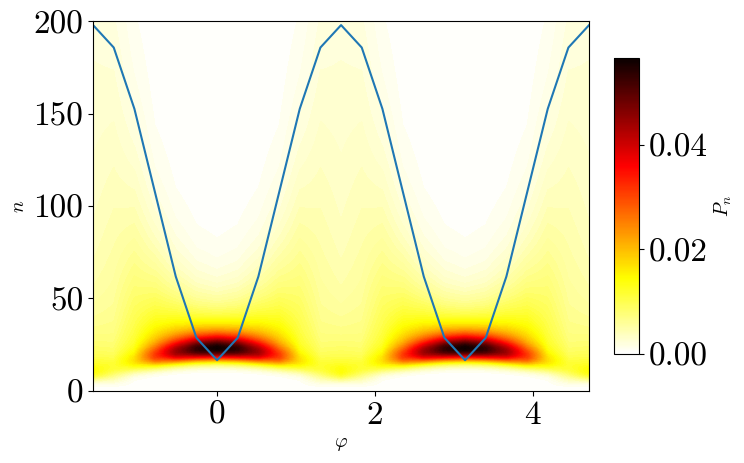

In [118]:
fig,ax = plt.subplots()

nrm = mpl.colors.Normalize(0,np.abs(np.array((n_dist)).max())) # Colorbar settings
cbar = fig.colorbar(cm.ScalarMappable(norm=nrm, cmap=cm.hot_r),cax = ax.inset_axes([1.05, 0.1, 0.05, 0.8]))
cbar.set_label('$P_n$',fontsize=14)

ax.contourf(phi,np.linspace(0,N-1,N),np.transpose(np.array((n_dist))), 100, cmap=cm.hot_r, norm=nrm) # Plot of the distribution
ax.plot(phi,25*(np.cosh(2*r)-np.sinh(2*r)*np.cos(theta+2*(phi+np.pi/2)))+np.sinh(2*r)**2)

plt.xlim([np.min(phi),np.max(phi)]) # Figure settings
plt.ylim([0,200])
# plt.title('Photon number distribution',fontsize=14)
plt.xlabel(r'$\varphi$',fontsize=14)
plt.ylabel('$n$',fontsize=14)
plt.show()

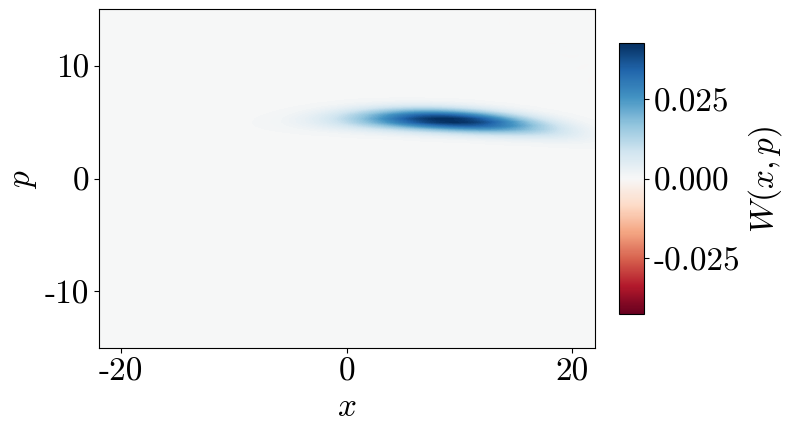

In [115]:
wigner_rep(rhos = rho_ss[14]).wigner_plot(22,15)

### 2. Wigner distribution

In [87]:
# wigner_rep(rhos = rho_ss).wigner_animation(22,15,phi,figname = 'Heff_Var_PHI',speed = 100, mrname = r'$\varphi$') # Create an animation for the whole range of phi

### 3. Quadrature fluctuations

In [99]:
quad_ang = np.pi-(theta)/2 # Quadrature angle that specifies the field's quadrature to measure
X_ang = a*np.exp(-1j*quad_ang)+a.dag()*np.exp(1j*quad_ang) # Chosen quadrature operator

In [100]:
def x_ang(ang):
    return a*np.exp(-1j*ang)+a.dag()*np.exp(1j*ang) # Chosen quadrature operator

In [101]:
fluc = np.zeros(np.size(phi), dtype = complex)
for i in range(np.size(phi)):
    fluc[i] = np.sqrt(expect(X_ang**2,rho_ss[i])-expect(X_ang,rho_ss[i])**2)

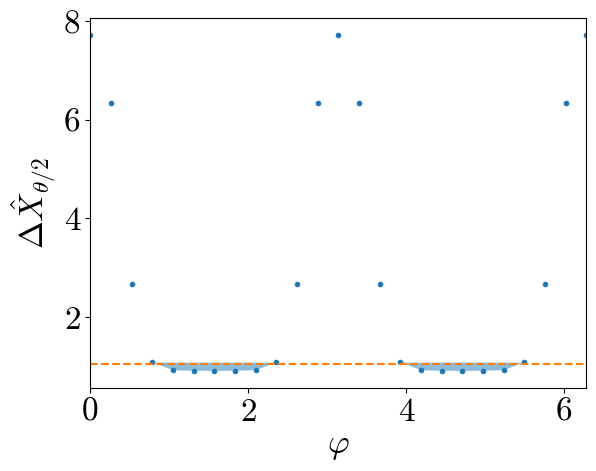

In [124]:
plt.plot(phi+np.pi/2,fluc,'.')
plt.plot([np.min(phi+np.pi/2),np.max(phi+np.pi/2)],[1.05,1.05],'--')
plt.fill_between(phi+np.pi/2,1.07,fluc,alpha=0.5,where=np.array(fluc)<1.1)
plt.xlim([np.min(phi+np.pi/2),np.max(phi+np.pi/2)])
# plt.title('Quadrature fluctuations',fontsize=14)
plt.xlabel(r'$\varphi$')
plt.ylabel(r'$\Delta\hat{X}_{\theta/2}$')
#plt.yscale('log')
plt.show()

In [125]:
esp = np.column_stack([phi,fluc])
np.savetxt('./PHI_VAR_'+str(format(omega,'.1f'))+'_'+str(format(C,'.1f'))+'_'+str(format(r,'.2f'))+'.txt',esp)
